In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic
from os.path import exists

In [2]:
UnitVelocity_in_cm_per_s = 1e5		
UnitVelocity_in_km_per_s = UnitVelocity_in_cm_per_s / 1e5
UnitLength_in_cm = 3.085678e18 	# pc
UnitMass_in_g = 1.989e31		# 0.01 solar masses

BoxSize = 48


UnitTime_in_s = UnitLength_in_cm / UnitVelocity_in_cm_per_s
TimeBetSnapshot_in_s = 0.0002 * UnitTime_in_s
TimeBetSnapshot_in_yr = TimeBetSnapshot_in_s / 60 / 60 / 24 / 365
frameAmount = 20
frameNbrMultiplier = 20

timeScaleToYears = np.linspace(0,TimeBetSnapshot_in_yr*(frameAmount-1),frameAmount)

folderPath = "../run/1_clusters/"

#dataFolders = ["20_0_cluster_dt_0_cRad_0_density_1_nstar_1_E_1e51erg_boxSize_48_res_128", "20_1_cluster_dt_0_cRad_0pc_density_1_nstar_5_E_1e51erg_boxSize_48_res_128", "20_2_cluster_dt_0_cRad_10pc_density_1_nstar_5_E_1e51erg_boxSize_48_res_128"]
#dataFolders = ["19_0_cluster_dt_0_ds_0_density_1_nstar_1_boxSize_48_res_128", "19_0_cluster_dt_0_ds_0_density_1_nstar_10_boxSize_48_res_128", "19_0_cluster_dt_0_ds_0_density_1_nstar_100_boxSize_48_res_128"]
dataFolders = ["1_5_cluster_dt_0_cRad_10pc_density_1_nstar_100_E_1e51erg_boxSize_48_res_128"]


0
0
1
2
3
4
5
6
7
8
9


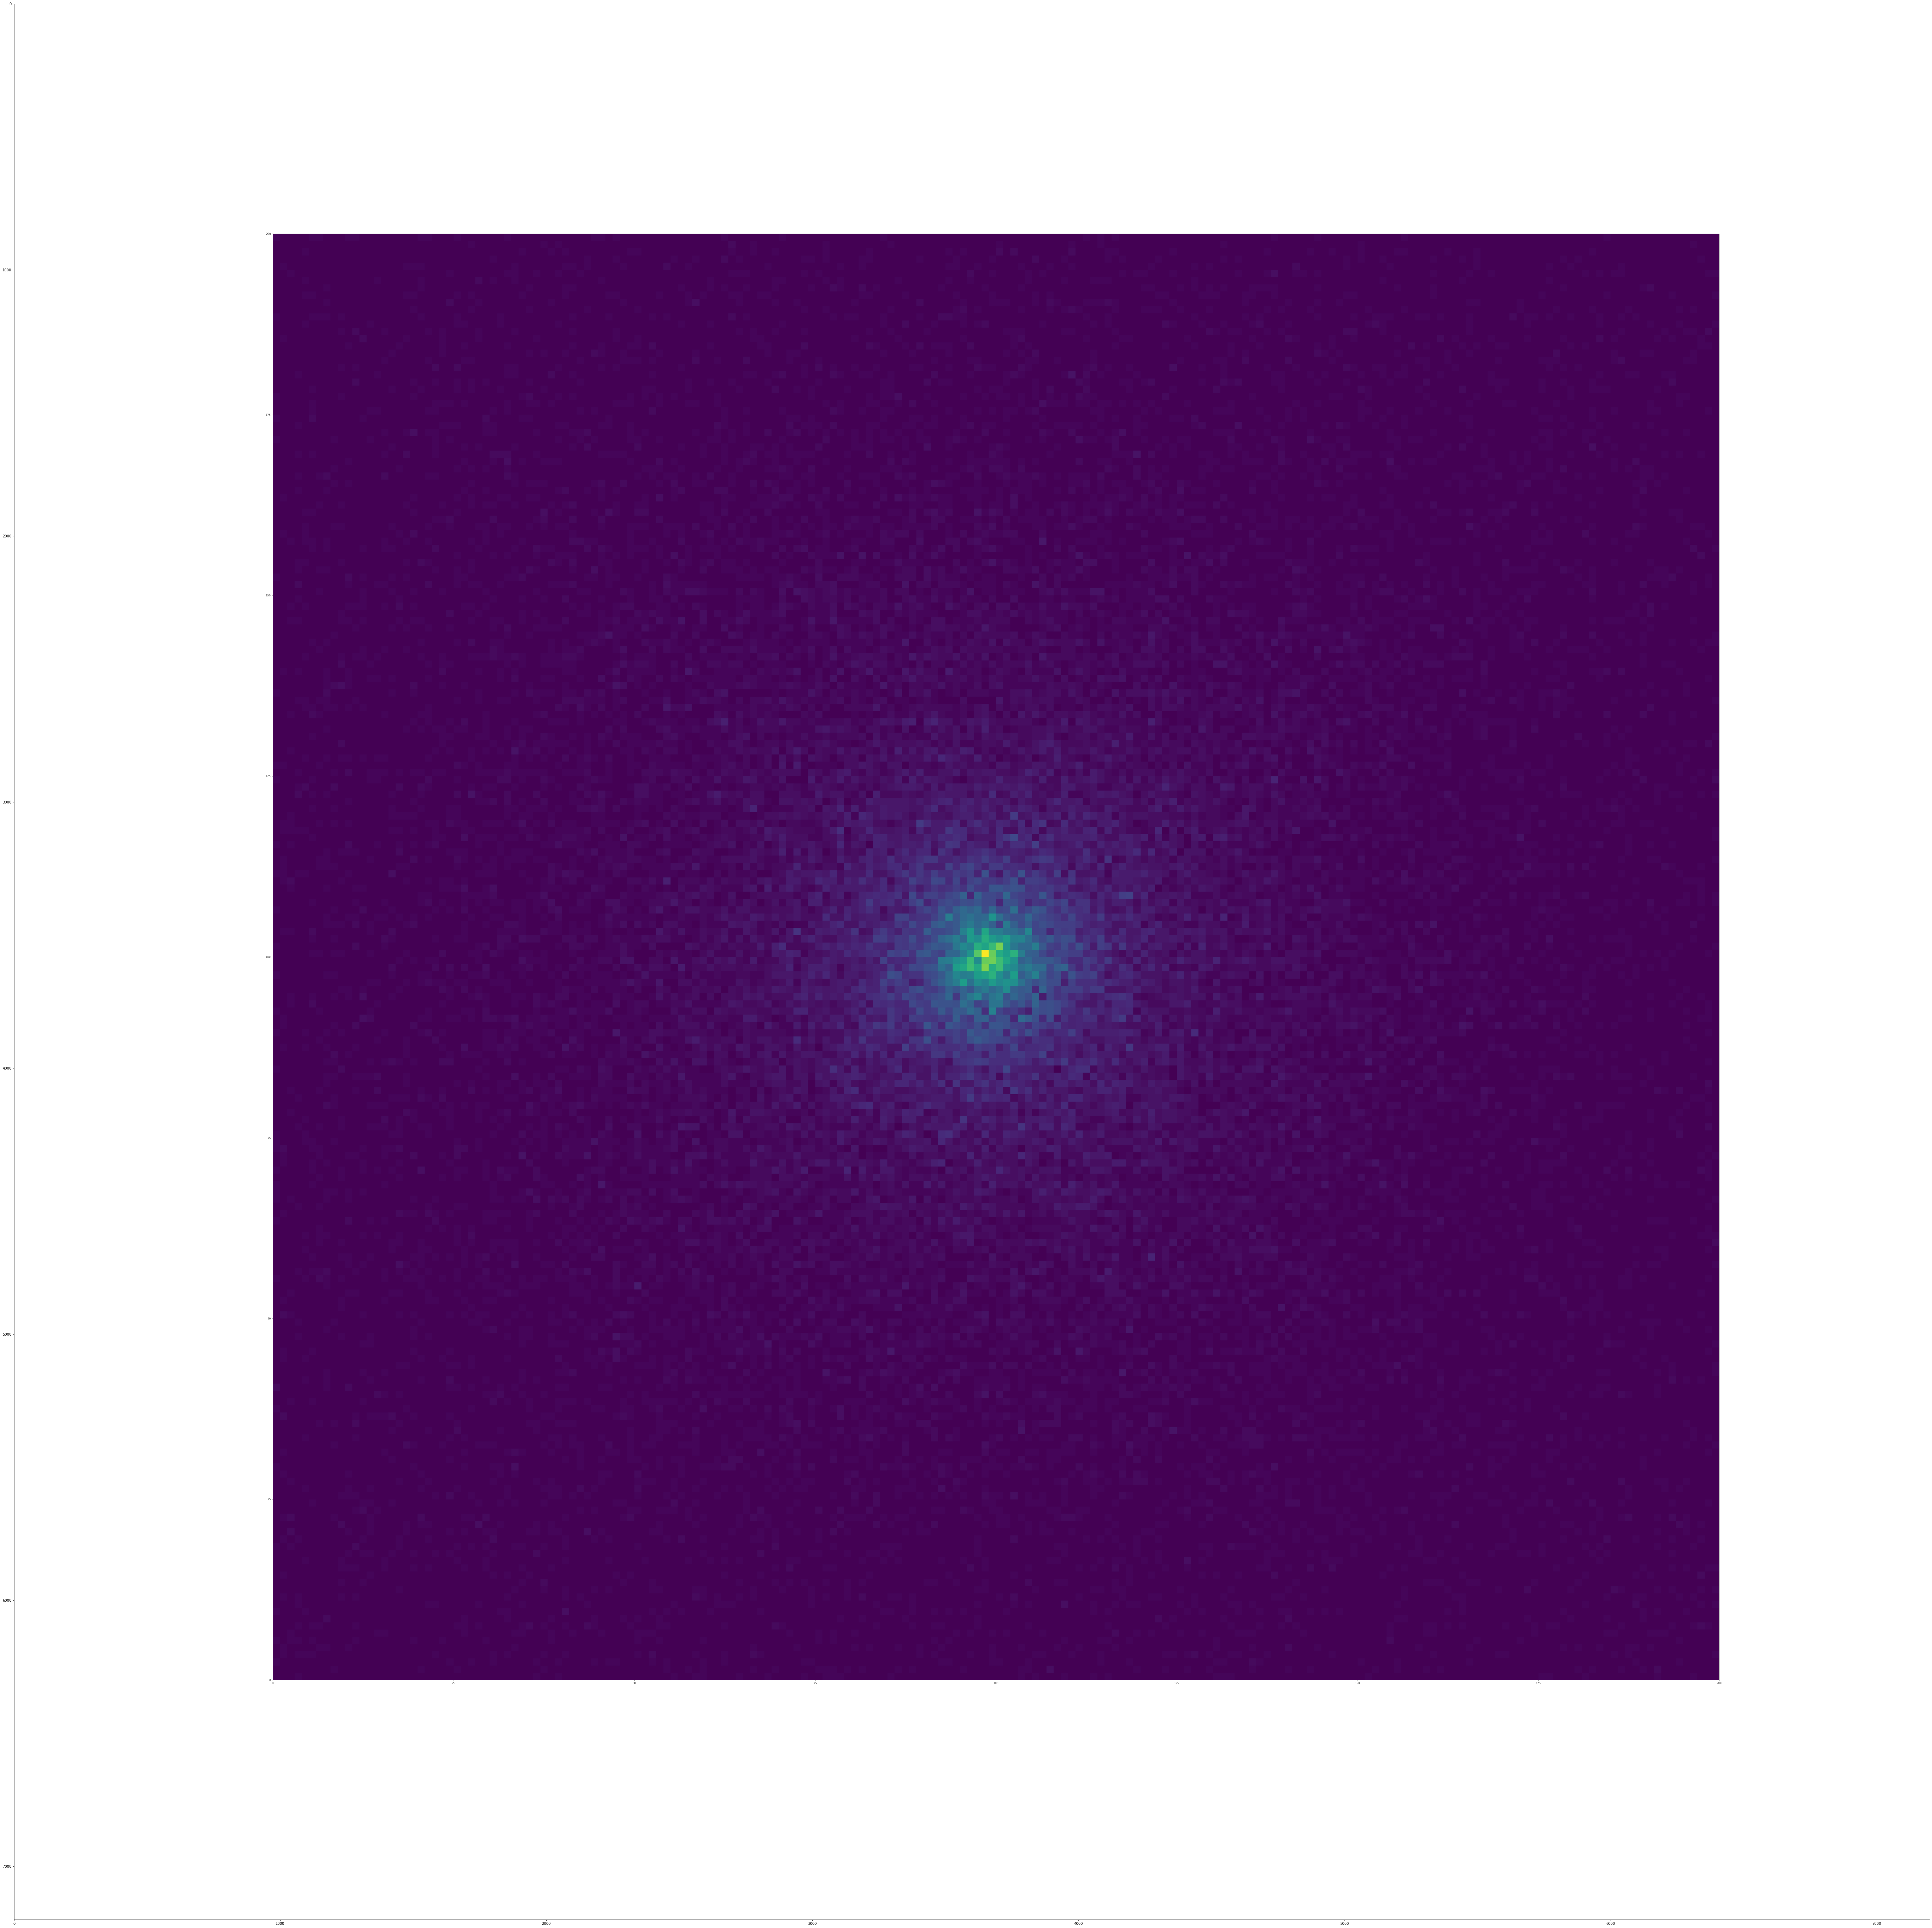

In [5]:
import matplotlib.animation as animation
import matplotlib.image as mpimg

folder = "/vera/u/xboecker/run/4_galaxy/2_scale_SN_cluster/output/"
folder = "/vera/u/xboecker/run/4_galaxy/xeno_diskIC/run_diskIC_wdm/output_no_cooling_or_SFR/"

frameAmount = 10

fig, ax = plt.subplots(figsize = (100,100))
#plt.axis([0, 400, 0, 300])


def animate(timeStep):
    print(timeStep)
    plt.clf()
    img = mpimg.imread("plots/galaxyHist2d_run_diskIC_wdm"+str(timeStep*30).zfill(3)+".png")
    plt.imshow(img)
anim = animation.FuncAnimation(fig, animate,
                               frames=frameAmount)#,
                               #interval=5,
                               #repeat=False)

f = r"plots/galaxyHist2d_run_diskIC_wdm_10_frames.gif" 
writergif = animation.PillowWriter(fps=10) 
anim.save(f, writer=writergif)

plt.show()

### Kinetic Energy

In [3]:
def getTotalKineticEnergy(timeStep, folder):
    with h5py.File(folderPath+folder + "/output"+"/snap_"+str(timeStep).zfill(3) +".hdf5", "r") as hdf:
        masses = np.array(hdf.get("PartType0/Masses"))
        velocities = np.array(hdf.get("PartType0/Velocities"))
    
    absVelocities = np.zeros(len(velocities))
    for i in range(len(velocities)):
            absVelocities[i] = np.sqrt(velocities[i][0]**2 + velocities[i][1]**2 + velocities[i][2]**2)
    
    kineticEnergies = 0.5 * masses * absVelocities*2
    return np.sum(kineticEnergies)

In [4]:
totalKineticEnergy = np.zeros((len(dataFolders),frameAmount))

for i in range(len(dataFolders)):
    print("folder "+str(i))
    if(exists("data/totalKineticEnergy"+dataFolders[i])):
        totalKineticEnergy[i] = np.loadtxt("data/totalKineticEnergy"+dataFolders[i])
    else:
        for j in range(frameAmount):
            totalKineticEnergy[i,j] = getTotalKineticEnergy(j * frameNbrMultiplier, dataFolders[i])
            print(j)

        np.savetxt("data/totalKineticEnergy"+dataFolders[i], totalKineticEnergy[i])
    #print(iE[i])

folder 0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


### Radial Velocities

In [7]:
def VelToRadialVel(velocities, coos):
    radialVelocities = np.zeros(len(velocities))
    for i in range(len(radialVelocities)):
        radialDirections = (coos[i] - np.array([1,1,1])) / np.linalg.norm(coos[i] - np.array([1,1,1])) #normed
        radialVelocities[i] = velocities[i][0] * radialDirections[0] + velocities[i][1] * radialDirections[1] + velocities[i][2] * radialDirections[2]
    return radialVelocities


def getRadialGasVelocities(timeStep, folder):
    with h5py.File(folderPath+folder + "/output"+"/snap_"+str(timeStep).zfill(3) +".hdf5", "r") as hdf:
        velocities = np.array(hdf.get("PartType0/Velocities"))
        coos = np.array(hdf.get("PartType0/Coordinates"))
        radVels = VelToRadialVel(velocities, coos)
        
        return radVels

In [10]:
radGasVelocities = np.zeros((len(dataFolders),frameAmount))

for i in range(len(dataFolders)):
    if(exists("data/radGasVelocities_"+dataFolders[i]) and len("data/radGasVelocities_"+dataFolders[i]) == frameAmount):
        #load data
        radGasVelocities[i] = np.loadtxt("data/radGasVelocities_"+dataFolders[i])
    else:
        #calculate and save new data
        for j in range(frameAmount):
            radGasVelocities[i,j] = np.max(getRadialGasVelocities(frameNbrMultiplier *j, dataFolders[i]))
        np.savetxt("data/radGasVelocities_"+dataFolders[i], radGasVelocities[i])


### Blastwave Radius (velocity cut)

In [11]:
def getBlastwaveSphereRadius(timeStep, folder):
    with h5py.File(folderPath + folder + "/output"+"/snap_"+str(timeStep).zfill(3) +".hdf5", "r") as hdf:
        coos = np.array(hdf.get("PartType0/Coordinates"))
        velocities = np.array(hdf.get("PartType0/Velocities"))
    
    absVelocities = np.zeros(len(velocities))
    distsFromCenter = np.zeros(len(velocities))
    for i in range(len(velocities)):
        absVelocities[i] = np.sqrt(velocities[i][0]**2 + velocities[i][1]**2 + velocities[i][2]**2)
        if(absVelocities[i] >= 1):
            distsFromCenter[i] = np.sqrt((coos[i][0]-BoxSize/2)**2 + (coos[i][1]-BoxSize/2)**2 + (coos[i][2]-BoxSize/2)**2)
        else:
            distsFromCenter[i] = 0
    
    return np.max(distsFromCenter)

def shellVelFromRadius(radii):
    shellVelocities = np.zeros(len(radii))
    shellVelocities[0] = radii[0] * UnitLength_in_cm / 1e3 / TimeBetSnapshot_in_s
    shellVelocities[1:] = (radii[1:] - radii[:-1]) * UnitLength_in_cm / 1e3 / TimeBetSnapshot_in_s
    
    return shellVelocities # in km/s

In [12]:
shellRadii = np.zeros((len(dataFolders),frameAmount))
for i in range(len(dataFolders)):
    if(exists("data/shellRadii"+dataFolders[i])):
        shellRadii[i] =np.loadtxt("data/shellRadii"+dataFolders[i])
    else:
        for j in range(frameAmount):
            shellRadii[i,j] = getBlastwaveSphereRadius(frameNbrMultiplier * j, dataFolders[i])
            print(j)
        np.savetxt("data/shellRadii"+dataFolders[i], momenta[i])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


### Momentum

In [3]:
def getMomentum(timeStep, folder):
    with h5py.File(folderPath+folder + "/output"+"/snap_"+str(timeStep).zfill(3) +".hdf5", "r") as hdf:
        masses = np.array(hdf.get("PartType0/Masses"))
        velocities = np.array(hdf.get("PartType0/Velocities"))
    
    absVelocities = np.zeros(len(velocities))
    for i in range(len(velocities)):
            absVelocities[i] = np.sqrt(velocities[i][0]**2 + velocities[i][1]**2 + velocities[i][2]**2)
    
    momenta = masses * absVelocities
    return sum(momenta)

In [5]:
momenta = np.zeros((len(dataFolders),frameAmount))

for i in range(len(dataFolders)):
    for j in range(frameAmount):
        momenta[i,j] = getMomentum(frameNbrMultiplier * j, dataFolders[i])
        print(j)
        
    np.savetxt("data/momenta"+dataFolders[i], momenta[i])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
